# Bundle Clustering

## 1. Importing / Installing Packages

In [5]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import folium

from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

from bayes_opt import BayesianOptimization

from src.database_manager import SQLTableManager
from src.custom_logger import CustomLogger

## 2. Initiliazing the Logger

In [6]:
# Create an instance of CustomLogger with logger name and log directory
logger_instance = CustomLogger("well_clustering","clustering",r"C:\Users\Apoorva.Saxena\OneDrive - Sitio Royalties\Desktop\Project - Apoorva\Python\Parent_Child_Spacing\src\logs")

# Get the logger
logger = logger_instance.get_logger()

## 3. Data Import

### 3.1 Reading WellHeader EXCEL to Df

In [7]:
# Reading WellHeader excel file to dataframe
df_raw_wellheader = pd.read_excel("WellHeader.xlsx",dtype={'ChosenID':str})

### 3.2 Importing Lat Long from Conduit DB

In [8]:
# Initiliazing the Database class
sql = SQLTableManager()

try:
    sql.connect()

    logger.debug("Reading Conduit SQL Query")

    query = f'''
                select 
                    cha.ChosenID,
                    cha.LeaseName,
                    cha.LeaseNumber,
                    cha.Field,
                    cha.CustomString2 as RES_CAT,
                    cha.CustomString0 as Landing_Zone,
                    cha.PerfLateralLength,
                    cha.FirstProdDate,
                    cha.CompletionStartDate as Comp_Dt,
                    cha.HoleDirection,
                    cha.SurfaceLatitude,
                    cha.SurfaceLongitude,
                    cha.ToeLatitude as BH_Lat,
                    cha.ToeLongitude as BH_Long
                from Conduit.dbo.CCWellHeaderAnalysis cha
                where cha.ChosenID in {tuple(df_raw_wellheader['ChosenID'].unique())}
            '''
    
    df_conduit_wellheader = sql.execute_query(query)
    
    # Converting First Prod/ Comp Column to PandasDatetime
    df_conduit_wellheader['FirstProdDate'] = pd.to_datetime(df_conduit_wellheader['FirstProdDate'])
    df_conduit_wellheader['Comp_Dt'] = pd.to_datetime(df_conduit_wellheader['Comp_Dt'])


    logger.debug(f"Succesfully read Conduit SQL Query to df_conduit_wellheader. Top 5 Rows:\n----------------------------------------\n{df_conduit_wellheader.head()}\n----------------------------------------\n")

except Exception as e:
    logger.error(f"Error occured while reading {query} from MsSQL server. Error Details:{e}")
finally:
    sql.close_connection()

[clustering] DEBUG (06-15 04:24 PM): Reading Conduit SQL Query (Line: 7) [3505071074.py]

[clustering] DEBUG (06-15 04:24 PM): Reading Conduit SQL Query (Line: 7) [3505071074.py]

c:\users\apoorva.saxena\onedrive - sitio royalties\desktop\project - apoorva\python\parent_child_spacing\src\database_manager.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql(sql_query, self.connection)
[clustering] DEBUG (06-15 04:24 PM): Succesfully read Conduit SQL Query to df_conduit_wellheader. Top 5 Rows:
----------------------------------------
     ChosenID                        LeaseName  LeaseNumber      Field  \
0  4238939261  JOHN PHILLIP LONG STATE 18-19 A  08-292705-G    PHANTOM   
1  4238939263  JOHN PHILLIP LONG STATE 18-19 C  08-292616-G    PHANTOM   
2  4238939262  JOHN PHILLIP LONG STATE 18-19 B  08-292637-G

In [9]:
# Merging conduit dataframe with wellheader dataframe
df_raw_merge = df_raw_wellheader.merge(df_conduit_wellheader,how='left', suffixes=['_df_WellHeader', '_df_Conduit'])

## 4. Data Preprocessing

### 4.1 Exploratory Data Analysis & Data Cleaning

In [10]:
# Checking for data types
df_raw_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3185 entries, 0 to 3184
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ChosenID           3185 non-null   object        
 1   Basin              3185 non-null   object        
 2   WellName           3185 non-null   object        
 3   County             3185 non-null   object        
 4   LeaseName          3185 non-null   object        
 5   LeaseNumber        2301 non-null   object        
 6   Field              3185 non-null   object        
 7   RES_CAT            3185 non-null   object        
 8   Landing_Zone       2717 non-null   object        
 9   PerfLateralLength  3171 non-null   float64       
 10  FirstProdDate      3185 non-null   datetime64[ns]
 11  Comp_Dt            2360 non-null   datetime64[ns]
 12  HoleDirection      3185 non-null   object        
 13  SurfaceLatitude    3185 non-null   float64       
 14  SurfaceL

In [11]:
# Checking for null values
df_raw_merge.isnull().sum()

ChosenID               0
Basin                  0
WellName               0
County                 0
LeaseName              0
LeaseNumber          884
Field                  0
RES_CAT                0
Landing_Zone         468
PerfLateralLength     14
FirstProdDate          0
Comp_Dt              825
HoleDirection          0
SurfaceLatitude        0
SurfaceLongitude       0
BH_Lat                10
BH_Long               10
dtype: int64

In [12]:
# Investigate all the elements within each feature
for column in df_raw_merge:
    unique_vals = df_raw_merge[column].unique()
    nr_values = len(unique_vals)
    if nr_values <= 10:
        print(f"The number of values for feature {column} :{nr_values:,} -- {unique_vals}")
    else:
        print(f"The number of values for feature {column} :{nr_values:,}")

The number of values for feature ChosenID :3,185
The number of values for feature Basin :1 -- ['DB']
The number of values for feature WellName :3,157
The number of values for feature County :1 -- ['REEVES']
The number of values for feature LeaseName :1,740
The number of values for feature LeaseNumber :1,385
The number of values for feature Field :21
The number of values for feature RES_CAT :10 -- ['01PDP' '03PA' '05PA' '02PDNP' '02PA' 'OLD DUC' 'EXPIRED PERM' '03PUD'
 '05PBUD' '07PBUD']
The number of values for feature Landing_Zone :15
The number of values for feature PerfLateralLength :2,399
The number of values for feature FirstProdDate :217
The number of values for feature Comp_Dt :1,442
The number of values for feature HoleDirection :3 -- ['H' 'V' 'D']
The number of values for feature SurfaceLatitude :3,128
The number of values for feature SurfaceLongitude :3,150
The number of values for feature BH_Lat :3,164
The number of values for feature BH_Long :3,166


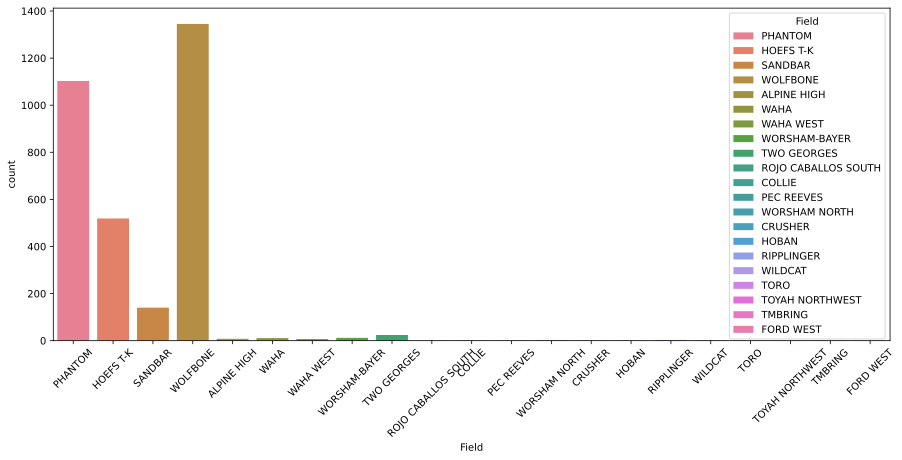

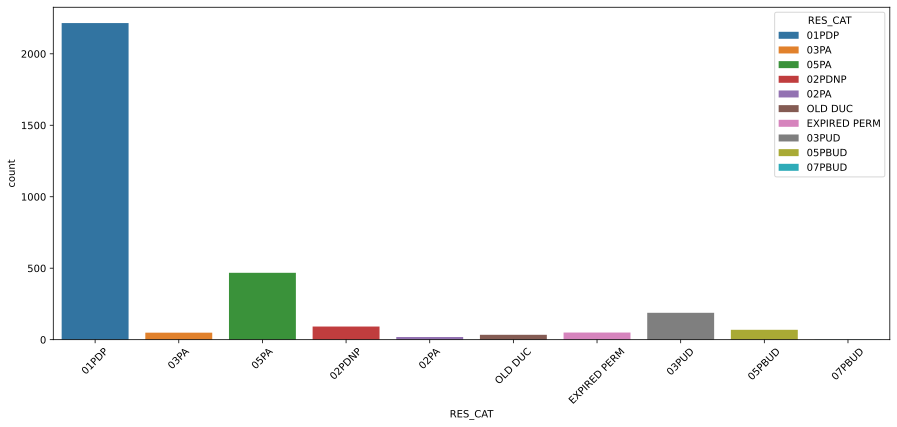

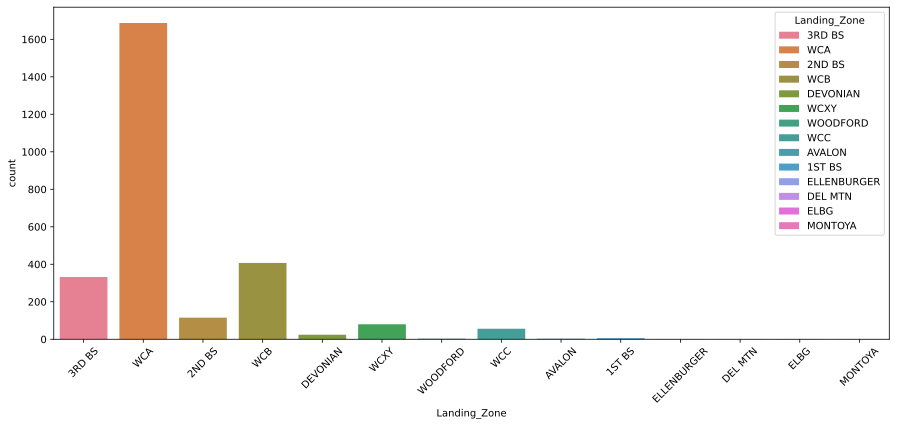

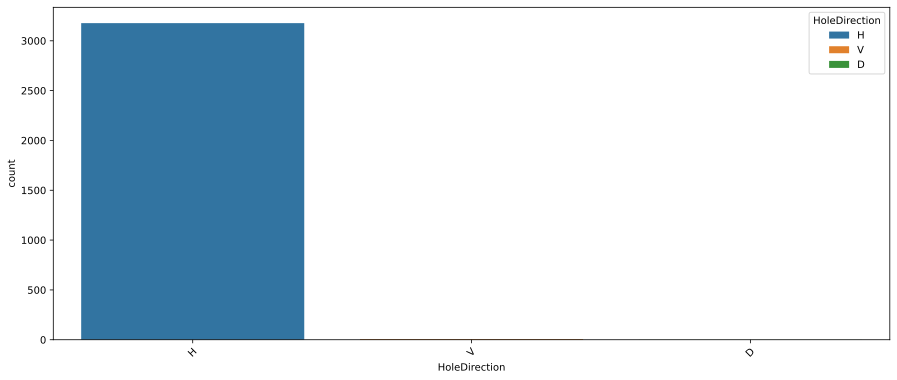

In [13]:
# Looping through all the features by our y variable - see if there is relationship
# object_cols = [col for col in df_raw.columns if df_raw[col].dtypes.name == 'object']

for f in ['Field','RES_CAT','Landing_Zone','HoleDirection']:
    # Set the figure size
    plt.figure(figsize=(15, 6))
    
    sns.countplot(x = f, data = df_raw_merge, hue=f,legend=True)
    plt.xticks(rotation=45)

## 5. Feature Engineering

In [14]:
# Keeping only Relevant Reserve Catg
df_raw_filter_ResvCat = df_raw_merge[(df_raw_merge['RES_CAT'].isin(['01PDP','02PA','02PDNP','03PUD']))].reset_index(drop=True).copy()

In [15]:
# Calculate the midpoints
df_raw_filter_ResvCat['mid_lat'] = np.where(df_raw_filter_ResvCat['BH_Lat'].isna(), df_raw_filter_ResvCat['SurfaceLatitude'], (df_raw_filter_ResvCat['SurfaceLatitude'] + df_raw_filter_ResvCat['BH_Lat']) / 2)
df_raw_filter_ResvCat['mid_long'] = np.where(df_raw_filter_ResvCat['BH_Long'].isna(), df_raw_filter_ResvCat['SurfaceLongitude'], (df_raw_filter_ResvCat['SurfaceLongitude'] + df_raw_filter_ResvCat['BH_Long']) / 2)

<Axes: xlabel='mid_lat', ylabel='mid_long'>

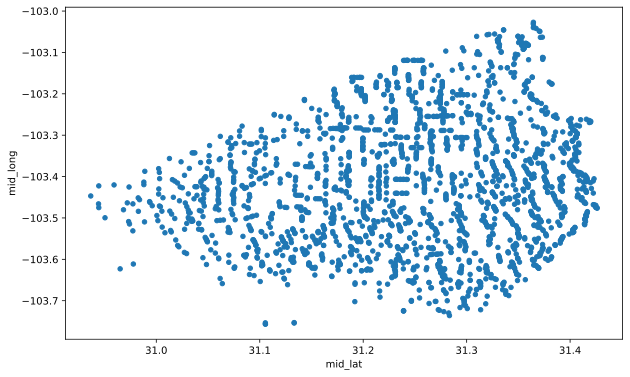

In [17]:
df_raw_filter_ResvCat.plot(kind='scatter',x='mid_lat',y='mid_long',figsize=(10,6))

## 6. DBSCAN

### 6.1 Defining Functions

In [23]:
def haversine_distance(lon1, lat1, lon2, lat2,**kwargs):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


def dbscan_cluster(latitudes,longitudes,epsilon,min_samples,**kwargs):
    '''
    Function to perform DBSCAN clustering for given parameters.
    
    '''
    
    # convert epsilon from km to radians
    kms_per_radian = 6371.0088
    epsilon /= kms_per_radian
    
    # set up the algorithm
    dbscan = DBSCAN(
        eps = epsilon,
        min_samples = min_samples,
        algorithm = 'ball_tree',
        metric = 'haversine',
        **kwargs
    )
    
    # fit the algorithm
    dbscan.fit(
        np.radians(
            [x for x in zip(latitudes,longitudes)]
        )
    )
    
    # return the cluster labels
    return pd.Series(dbscan.labels_)


def vertex_centroid_distance(latitudes,longitudes,**kwargs):
    '''
    Function to calculate the average distance from the vertices of a convex hull
    (derived from latitude x longitude pairs) to the centroid of said convex hull.
    
    Centroid is taken to be the unweighted average of all co-ordinate pairs.
    
    '''
    
    # co-ordinates of centre
    # take a simple average
    centre_long = longitudes.mean()
    centre_lats = latitudes.mean()
    
    # collapse two points into line
    if len(latitudes) < 3:
        distances = haversine_distance(
            longitudes,
            latitudes,
            centre_long,
            centre_lats,
            **kwargs).mean()
    
    else:
        # convex hull
        convex_hull = ConvexHull([x for x in zip(latitudes,longitudes)],**kwargs)

        # now get co-ordinates of vertices
        vertex_longs = longitudes.iloc[convex_hull.vertices]
        vertex_lats = latitudes.iloc[convex_hull.vertices]

        # now get
        distances = haversine_distance(
            vertex_longs,
            vertex_lats,
            centre_long,
            centre_lats,
            **kwargs).mean()

    # return average distance
    return distances.mean() if not np.isnan(distances) else 0.0


def calculate_average_values_in_disctionary(dictionary:dict):
    return -1*(sum(dictionary.values())/len(dictionary)) if dictionary else None


def black_box_function(epsilon, min_samples):
    """
    Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.

    DataFrame: Dataframe with Lat & Long
    """
    df = df_raw_filter_ResvCat[['mid_lat','mid_long']].copy()

    df.drop_duplicates(inplace=True)

    df['cluster'] = dbscan_cluster(latitudes=df['mid_lat'],longitudes=df['mid_long'],
                                   epsilon=epsilon,min_samples=int(min_samples))
    
    vertex_dist = {}

    for cluster in df['cluster'].unique():

        df_cluster_lat_longs = df[df['cluster']==cluster].loc[:,['mid_lat','mid_long']].copy()

        vertex_dist[cluster] = vertex_centroid_distance(latitudes=df_cluster_lat_longs['mid_lat'], longitudes=df_cluster_lat_longs['mid_long'])

    return calculate_average_values_in_disctionary(vertex_dist)


def plot_clusters(df:pd.DataFrame,eps:float,min_samp:int):

    df_result = df.copy()

    df_result['cluster'] = dbscan_cluster(latitudes=df_result['mid_lat'],longitudes=df_result['mid_long'],
                                epsilon=eps, min_samples=min_samp)
    

    m = folium.Map(location=[df_result['mid_lat'].mean(), df_result['mid_long'].mean()], 
                tiles="OpenStreetMap", zoom_start=11)
    
    # Create a colormap for the unique cluster labels
    cmap = plt.get_cmap('hsv', len(df_result['cluster'].unique()))

    # Create a color dictionary for each unique cluster
    colors = {cluster: matplotlib.colors.rgb2hex(cmap(i)) for i, cluster in enumerate(df_result['cluster'].unique())}

    # Add a circle marker for each point
    for _, row in df_result.iterrows():
        folium.CircleMarker(
            location=[row['mid_lat'], row['mid_long']],
            radius=5, # Defines the radius of the circle marker
            color="white",
            fill=True,
            popup = f"{row['WellName']}, Cluster: {row['cluster']}",
            fill_color=colors[row['cluster']],
            fill_opacity=1
        ).add_to(m)


    # Return the map
    return m, df_result

### 6.2 Running Bayesian Optimization

In [29]:
# Bounded region of parameter space
pbounds = {'epsilon': (0.1, 0.2), 'min_samples': (1, 3)}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=0,
    allow_duplicate_points=True
)

In [30]:
optimizer.maximize()

|   iter    |  target   |  epsilon  | min_sa... |
-------------------------------------------------
| 1         | -0.1122   | 0.1549    | 2.43      |
| 2         | -0.1136   | 0.1603    | 2.09      |
| 3         | -0.1111   | 0.1424    | 2.292     |
| 4         | -0.1109   | 0.1438    | 2.784     |
| 5         | -0.02602  | 0.1964    | 1.767     |
| 6         | -0.02684  | 0.2       | 1.591     |
| 7         | -0.005843 | 0.1       | 1.148     |
| 8         | -0.1173   | 0.1832    | 2.28      |
| 9         | -0.02671  | 0.1996    | 1.001     |
| 10        | -0.006904 | 0.1041    | 1.149     |
| 11        | -0.005843 | 0.1       | 1.375     |
| 12        | -0.005843 | 0.1       | 1.664     |
| 13        | -0.1173   | 0.1082    | 2.629     |
| 14        | -0.005843 | 0.1       | 1.0       |
| 15        | -0.02354  | 0.1831    | 1.336     |
| 16        | -0.005862 | 0.1001    | 1.27      |
| 17        | -0.005843 | 0.1       | 1.528     |
| 18        | -0.005895 | 0.1002    | 1.065     |


### 6.3 Getting and Plotting Final DB Cluster

In [31]:
m, df_with_clusters = plot_clusters(df=df_raw_filter_ResvCat, eps=0.1964, min_samp=1)
m

In [32]:
df_with_clusters.to_clipboard(sep=',',index=False)

## 7. Fixing Clusters